In [1]:
import torch

import math

import numpy as np

import torch as th

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib.pyplot import hist

In [2]:
def normpdf(x, mean=torch.tensor(0.0), scale=torch.tensor(1.)):
    e = -(x - mean)**2. / (2. * scale**2)
    return torch.exp(e) / (torch.sqrt(2 * torch.tensor(math.pi)) * scale)

In [3]:
normpdf(torch.tensor(1.0))

tensor(0.2420)

In [4]:
x = torch.tensor(-0.1, requires_grad=True)

In [5]:
y = normpdf(x)
y.backward()
x.grad

tensor(0.0397)

In [6]:
isinstance(x, torch.Tensor)

True

In [7]:
def ptilde(x):
    return 0.3 * normpdf(x, mean=torch.tensor(4.0), scale=torch.tensor(1.0)) + 0.7 * normpdf(x, mean=torch.tensor(7.0), scale=torch.tensor(1.0))

In [8]:
x = torch.tensor(4.5, requires_grad=True)
y = ptilde(x)
y.backward()
x.grad

tensor(-0.0221)

In [9]:
x = th.tensor(np.linspace(0, 10, num=100))

In [10]:
y = x.clone().apply_(ptilde)

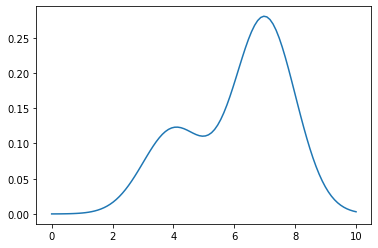

In [11]:
plt.plot(np.array(x), np.array(y))

## leapfrog

\begin{align}
\widehat{r}(t+\epsilon / 2) & = \widehat{r}(t) - \frac{\epsilon}{2}\frac{\partial E}{\partial z}(\widehat{z}(t))\\
\widehat{z}(t+\epsilon / 2) & = \widehat{z}(t) + \epsilon \widehat{r}(t+\epsilon / 2)\\
\widehat{r}(t+\epsilon) & = \widehat{r}(t+\epsilon / 2) - \frac{\epsilon}{2}\frac{\partial E}{\partial z}(\widehat{z}(t+\epsilon))
\end{align}

In [12]:
import random
from random import randint
def leapfrog(z, r, e=torch.tensor(0.001), L=100):
    if randint(1,2) == 1:
        e = -e
    l = L * 0.2
    L += int(random.random() * l)
    for _ in range(L):
        z.requires_grad_(True)
        E = -torch.log(ptilde(z))
        E.backward()
        #print(z.grad)
        with torch.no_grad():
            rhalf = r - 0.5 * e * z.grad
            znext = z + e * rhalf
        #print(znext)
        znext.requires_grad_(True)
        E2 = -torch.log(ptilde(znext))
        E2.backward()
        #print(znext.grad)
        with torch.no_grad():
            rnext = rhalf - 0.5 * e * znext.grad
            z = znext
            r = rnext
    return z, r

In [13]:
def Hamilton(z, r):
    def E(z):
        return -torch.log(ptilde(z))
    def K(r):
        return 0.5 * r ** 2
    return E(z) + K(r)

In [14]:
z = torch.tensor(5.0, requires_grad=True)
r = torch.tensor(0.2, requires_grad=True)
print(Hamilton(z, r))
zn, rn = leapfrog(z, r, e=torch.tensor(0.1), L=100)
print(zn, rn)
print(Hamilton(zn, rn))

tensor(2.2238, grad_fn=<AddBackward0>)
tensor(8.3692, requires_grad=True) tensor(0.0934)
tensor(2.2173, grad_fn=<AddBackward0>)


In [15]:
random.random()

0.6415475606179768

In [16]:
def hmc1():
    n = 5000
    zs = []
    rs = []
    z0 = torch.tensor(4.0)
    for _ in range(n):
        r0 = torch.randn(1)
        zn, rn = leapfrog(z0, r0, e=torch.tensor(0.25), L=10)
        nH = Hamilton(zn, rn)
        oH = Hamilton(z0, r0)
        if random.random() <= torch.exp(-nH - (-oH)):
            z0 = zn
        zs.append(z0.item())

    _ = hist(zs, bins=150)

In [17]:
def leapfrog2(z, r, e=torch.tensor(0.001), L=100):
    if randint(1,2) == 1:
        e = -e
    z.requires_grad_(True)
    E = -torch.log(ptilde(z))
    E.backward()
    #print(z.grad)
    rhalf = r - 0.5 * e * z.grad
    rnext = rhalf
    znext = z

    for _ in range(L):
        with torch.no_grad():
            znext = znext + e * rnext
        #print(znext)
        znext.requires_grad_(True)
        E2 = -torch.log(ptilde(znext))
        E2.backward()
        #print(znext.grad)
        with torch.no_grad():
            rnext = rnext - e * znext.grad

    with torch.no_grad():
        rnext = rnext + 0.5 * e * znext.grad

    return znext, rnext

In [18]:
def hmc2():
    n = 5000
    zs = []
    rs = []
    z0 = torch.tensor(4.0)
    for _ in range(n):
        r0 = torch.randn(1)
        zn, rn = leapfrog2(z0, r0, e=torch.tensor(0.15), L=20)
        nH = Hamilton(zn, rn)
        oH = Hamilton(z0, r0)
        if random.random() <= torch.exp(-nH - (-oH)):
            z0 = zn
        zs.append(z0.item())

    _ = hist(zs, bins=150)

## Metropolis

In [19]:
import scipy as sci

In [20]:
norm = sci.random.normal(4, 2)

In [21]:
def metropolis():
    n = 5000
    xs = []
    x0 = 5
    for _ in range(n):
        q = sci.random.normal(x0, scale=1.)
        A = min(1, ptilde(q)/ptilde(x0))
        u = random.random()
        if u <= A:
            x0 = q
        xs.append(x0)

    _ = hist(xs, bins=150)

## PyMC3

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

In [23]:
import math

In [24]:
def logptilde2(x):
    return np.log(ptilde2(x))

In [25]:
def normpdf2(x, mean=0.0, scale=1.):
    e = -(x - mean)**2. / (2. * scale**2)
    return np.exp(e) / (np.sqrt(2 * math.pi) * scale)

In [26]:
def ptilde2(x):
    return 0.3 * normpdf2(x, mean=4.0, scale=1.0) + 0.7 * normpdf2(x, mean=7.0, scale=1.0)

In [27]:
def pymc3_hmc():
    model = pm.Model()
    with model:
        dist = pm.DensityDist('ptilde_dist', logptilde2)
    with model:
        step = pm.HamiltonianMC()
        trace = pm.sample(draws=5000, step=step, chains=2, return_inferencedata=False)

    #pm.summary(trace)

    _ = hist(trace['ptilde_dist'], bins=150)

## Gradient of log probability

In [28]:
xs = np.linspace(0, 10, 200)

In [29]:
dy = []
for x in xs:
    x = torch.tensor(x, requires_grad=True)
    E = torch.log(ptilde(x))
    E.backward()
    dy.append(x.grad)


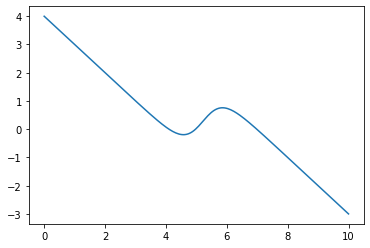

In [30]:
plt.plot(xs, dy)

In [31]:
xs = np.linspace(0, 10, 200)
ys = np.linspace(-4, 4, 200)
xx, yy = np.meshgrid(xs, ys)
#xx = xx.reshape(-1)
#yy = yy.reshape(-1)
#xx.shape, yy.shape

In [32]:
def gmptilde(x, y):
    return np.exp(-Hamilton2(x, y))

In [33]:
def Hamilton2(z, r):
    def E(z):
        return -np.log(ptilde2(z))
    def K(r):
        return 0.5 * r ** 2
    return E(z) + K(r)

In [34]:
zs = np.zeros((200, 200), dtype=np.float)
for i in range(200):
    for j in range(200):
        zs[i, j] = gmptilde(xx[i,j], yy[i,j])

In [35]:
np.max(zs), np.min(zs)

(0.2805620888736207, 1.3468513913412603e-08)

In [36]:
from matplotlib.pyplot import contour

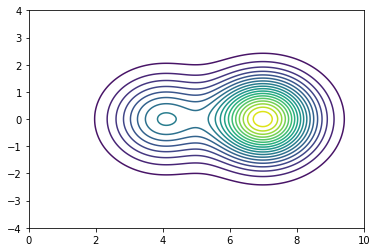

In [37]:
levels = np.arange(0,0.3,0.015)
contour(xx, yy, zs, levels=levels)

## Animation

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from matplotlib.animation import FuncAnimation
from matplotlib import rc

rc('animation', html='html5')


In [39]:
def leapfrog3(z, r, e=torch.tensor(0.001), L=100):
    if randint(1,2) == 1:
        e = -e
    z.requires_grad_(True)
    E = -torch.log(ptilde(z))
    E.backward()
    #print(z.grad)
    rhalf = r - 0.5 * e * z.grad
    rnext = rhalf
    znext = z

    for _ in range(L):
        with torch.no_grad():
            znext = znext + e * rnext
        #print(znext)
        znext.requires_grad_(True)
        E2 = -torch.log(ptilde(znext))
        E2.backward()
        #print(znext.grad)
        with torch.no_grad():
            rnext = rnext - e * znext.grad
        yield (znext, rnext)

    with torch.no_grad():
        rnext = rnext + 0.5 * e * znext.grad

    yield znext, rnext

In [40]:
class Traj(object):
    def __init__(self, ax, z0=1.0):
        self.ax = ax
        self.line, = self.ax.plot([],[],'k.')
        
        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(-4, 4)
        self.zs = []
        self.rs = []
        self.z0 = torch.tensor(z0)
    def _update(self):
        self.zs = []
        self.rs = []
        r0 = torch.randn(1)
        for zn, rn in leapfrog3(self.z0, r0, e=torch.tensor(0.15), L=20):
            self.zs.append(zn)
            self.rs.append(rn)
        nH = Hamilton(zn, rn)
        oH = Hamilton(self.z0, r0)
        if random.random() <= torch.exp(-nH - (-oH)):
            self.z0 = zn

    def init(self):
        self._update()
        return self.line,
    def __call__(self, i):
        if i == 0:
            return self.init()
        if i % 20 == 0:
            self._update()

        self.line.set_data(self.zs[:i%20], self.rs[:i%20])
        return self.line,


In [41]:
%%capture
fig, ax = plt.subplots()
levels = np.arange(0,0.3,0.015)
ax.contour(xx, yy, zs, levels=levels)
traj = Traj(ax, 4.0)
anim = FuncAnimation(fig, traj, frames=np.arange(200), init_func=traj.init, interval=200, blit=True)

In [42]:
#anim